In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

In [2]:
df= pd.read_csv('../data/data_income.csv')
df.head()

,Unnamed: 0,alias,category,city,id,latitude,longitude,price,rating,review_count,zip_code,ave_agi
0,0,いざかや-おせん-izakaya-osen-los-angeles,"['sushi', 'izakaya', 'seafood']",Los Angeles,us0WnDOySVXXXwCqs0AaCw,34.083192,-118.273245,2,4.5,651.0,90026.0,44.191297
1,1,yummy-crepe-stand-los-angeles,"['streetvendors', 'creperies']",Los Angeles,xFMzCotq4cURN37cvTr9eQ,34.078743,-118.263756,1,4.5,3.0,90026.0,44.191297
2,2,yum-yum-shave-ice-los-angeles-2,"['shavedice', 'foodstands']",Los Angeles,Tub-psQGYAjbtny6MnfQmg,34.077049,-118.258873,1,5.0,2.0,90026.0,44.191297
3,3,yoga-urt-los-angeles,"['icecream', 'juicebars', 'vegan']",Los Angeles,vsRKNraKeeddoOXL2btQ5A,34.077688,-118.265555,1,4.5,46.0,90026.0,44.191297
4,4,yami-yaki-los-angeles-2,['teppanyaki'],Los Angeles,Bcp6NEv7CGTOtnIgvo6Unw,34.077917,-118.263523,1,4.5,74.0,90026.0,44.191297


In [3]:
df.shape

(9657, 12)

In [4]:
df.drop(columns = ['id','Unnamed: 0'], inplace = True)

## Tried CountVectorizer to make the matrix of category and analyse the result, it did not turn well. So eleminate that part from model

In [5]:
#cvec = CountVectorizer()

In [6]:
#X = df['category']
#y=df['ave_agi']

In [31]:
#df_cato = pd.DataFrame(cvec.fit_transform(X).toarray(),
                  #columns=cvec.get_feature_names())
#df_cato.head()

In [ ]:
#df_cato.shape

In [8]:
#df['zip_code'].nunique()

170

In [9]:
#pd.concat([df, df_cato], axis=1)

In [10]:
#df_cato = pd.concat([df, df_cato], axis=1)
#df_cato.head

In [ ]:
#type(df)

In [11]:
df.shape

(9657, 10)

In [ ]:
#df_cato.shape

In [12]:
numeric_data = df._get_numeric_data().columns

In [13]:
X = df._get_numeric_data().drop(columns=['ave_agi'])
#features = list(X.columns)
y = df['ave_agi']

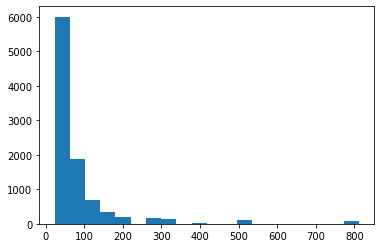

In [14]:
plt.hist(df["ave_agi"], bins=20);

In [15]:
y = np.log(df.copy()["ave_agi"])

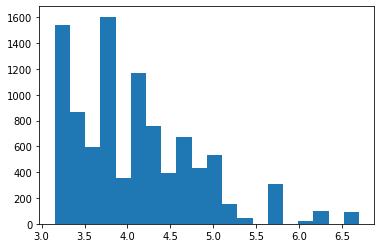

In [16]:
plt.hist(y, bins=20);

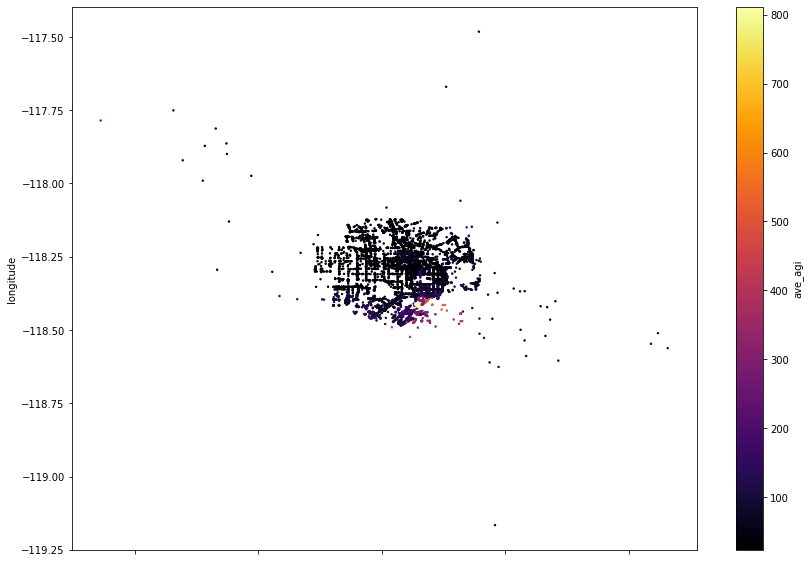

In [17]:
df.plot(kind="scatter", x="latitude", y="longitude", c="ave_agi",
         cmap="inferno", figsize=(14, 10), s=2);

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X.copy(), y.copy(), random_state=42, test_size=0.5
)

In [19]:
lr = LinearRegression()

In [20]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
lr.score(X_train, y_train)

0.4777630538497767

In [22]:
lr.score(X_test,y_test)

0.49764381650586254

In [23]:
location_data = df[["latitude", "longitude"]]
location_data.head()

,latitude,longitude
0,34.083192,-118.273245
1,34.078743,-118.263756
2,34.077049,-118.258873
3,34.077688,-118.265555
4,34.077917,-118.263523


In [24]:
km = KMeans(n_clusters=20)
km.fit(location_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

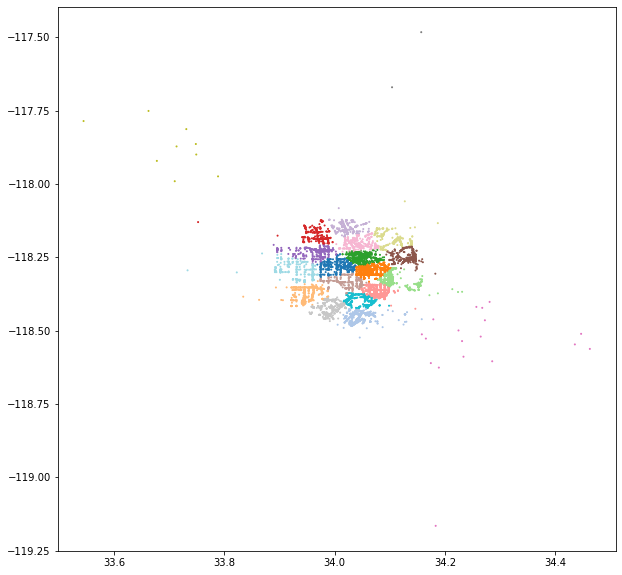

In [25]:
plt.figure(figsize=(10, 10))
plt.scatter(df.latitude, df.longitude, c=km.labels_, s=1, cmap="tab20");

In [26]:
X.loc[:, "cluster"] = km.predict(location_data)
X = pd.get_dummies(columns=["cluster"], data=X)
X.head()

,latitude,longitude,price,rating,review_count,zip_code,cluster_0,cluster_1,cluster_2,cluster_3,...,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19
0,34.083192,-118.273245,2,4.5,651.0,90026.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,34.078743,-118.263756,1,4.5,3.0,90026.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34.077049,-118.258873,1,5.0,2.0,90026.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34.077688,-118.265555,1,4.5,46.0,90026.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,34.077917,-118.263523,1,4.5,74.0,90026.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X.copy(), y.copy(), random_state=42, test_size=0.5
)

In [28]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6954208327701851

In [29]:
def transfer_tune(X, y, k):
    location_data = df[["latitude", "longitude"]]
    km = KMeans(n_clusters=k)
    km.fit(location_data)
    X.loc[:, "cluster"] = km.predict(location_data)
    X_dummy = pd.get_dummies(columns=["cluster"], data=X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.5
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    r2 = model.score(X_test, y_test)
    print(f"{k} : {r2}")

In [30]:
for k in range(2, 103, 5):
    transfer_tune(X, y, k)

2 : 0.6967986926637543
7 : 0.7035032769385456
12 : 0.7475063445965697
17 : 0.7569541229468478
22 : 0.7584051698140746
27 : 0.7782995333736415
32 : 0.7822266912292865
37 : 0.7775726135898753
42 : 0.8126851900238635
47 : 0.811481792751908
52 : 0.8288913565123561
57 : 0.8349109332515112
62 : 0.8366958428274304
67 : 0.8519323916306353
72 : 0.8503377715693983
77 : 0.8458492668081364
82 : 0.8554149601577447
87 : 0.8523520998850057
92 : 0.8668803201664967
97 : 0.8625046987344721
102 : 0.8594547137126459
